In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score

from data.dataset_utils import Subjects

In [4]:
df = pd.read_csv('features.csv')

In [33]:
def grid_search(features):
    train_subjects = Subjects.train
    test_subjects = Subjects.val
    X_train = features[features['subject_id'].isin(train_subjects)].iloc[:, :-2]
    y_train = features[features['subject_id'].isin(train_subjects)]['class'].replace({0: 0, 4: 1})
    X_test = features[features['subject_id'].isin(test_subjects)].iloc[:, :-2]
    y_test = features[features['subject_id'].isin(test_subjects)]['class'].replace({0: 0, 4: 1})

    X_combined = np.vstack((X_train, X_test))
    y_combined = np.hstack((y_train, y_test))
    test_fold = [-1] * len(X_train) + [0] * len(X_test)
    ps = PredefinedSplit(test_fold=test_fold)

    param_grid = {
        'n_estimators': [50, 80, 100, 120, 150, 200, 250, 300, 350, 400],
        'max_depth': [None, 2, 3, 4, 5, 6, 8, 10],
        'min_samples_split': [2, 3, 4, 5],
        'min_samples_leaf': [1, 1.5, 2]
    }

    grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='accuracy', n_jobs=-1, cv=ps)
    grid_search.fit(X_combined, y_combined)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best accuracy: {grid_search.best_score_}")


grid_search(df)

Best parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 120}
Best accuracy: 0.8461538461538461


In [ ]:
params = {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 120}

In [3]:
def leave_one_subject_out_CV(df, clf):
    subjects = df['subject_id'].unique()
    acc_scores = []
    recall_scores = []
    precision_scores = []
    auc_scores = []
    running_feature_importances = np.zeros(df.shape[1] - 2)

    for subject in subjects:
        X_train = df[df['subject_id'] != subject].iloc[:, :-2]
        y_train = df[df['subject_id'] != subject]['class'].replace({0: 0, 4: 1})
        X_test = df[df['subject_id'] == subject].iloc[:, :-2]
        y_test = df[df['subject_id'] == subject]['class'].replace({0: 0, 4: 1})

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        acc_scores.append(accuracy_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        auc_scores.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
        running_feature_importances += clf.feature_importances_

    return {
        'avg_acc': np.mean(acc_scores),
        'std_acc': np.std(acc_scores),
        'avg_prec': np.mean(precision_scores),
        'std_prec': np.std(precision_scores),
        'avg_rec': np.mean(recall_scores),
        'std_rec': np.std(recall_scores),
        'avg_auc': np.mean(auc_scores),
        'std_auc': np.std(auc_scores),
        'X_train': X_train,
        'feature_importance': running_feature_importances / len(subjects)
    }

In [ ]:
clf = RandomForestClassifier(random_state=42, **params)
evaluation = leave_one_subject_out_CV(df, clf)
print(f"Avg accuracy: {evaluation['avg_acc']:.4f} ± {evaluation['std_acc']:.4f}")
print(f"Avg precision: {evaluation['avg_prec']:.4f} ± {evaluation['std_prec']:.4f}")
print(f"Avg recall: {evaluation['avg_rec']:.4f} ± {evaluation['std_rec']:.4f}")
print(f"Avg AUC: {evaluation['avg_auc']:.4f} ± {evaluation['std_auc']:.4f}")

Avg accuracy: 0.8371 ± 0.1401
Avg precision: 0.8592 ± 0.1271
Avg recall: 0.7908 ± 0.2331
Avg AUC: 0.8991 ± 0.1262


In [4]:
# plot feature importances
def plot_feature_importance(evaluation, figsize=(10, 10)):
    x = evaluation['X_train']
    fi = evaluation['feature_importance']
    indices = np.argsort(fi)
    plt.figure(figsize=figsize)
    plt.barh(range(x.shape[1]), fi[indices], align="center")
    plt.yticks(range(x.shape[1]), np.array(x.columns)[indices])
    plt.ylim([-1, x.shape[1]])
    plt.xlabel("Gini-/impurity-based feature importance")
    plt.show()

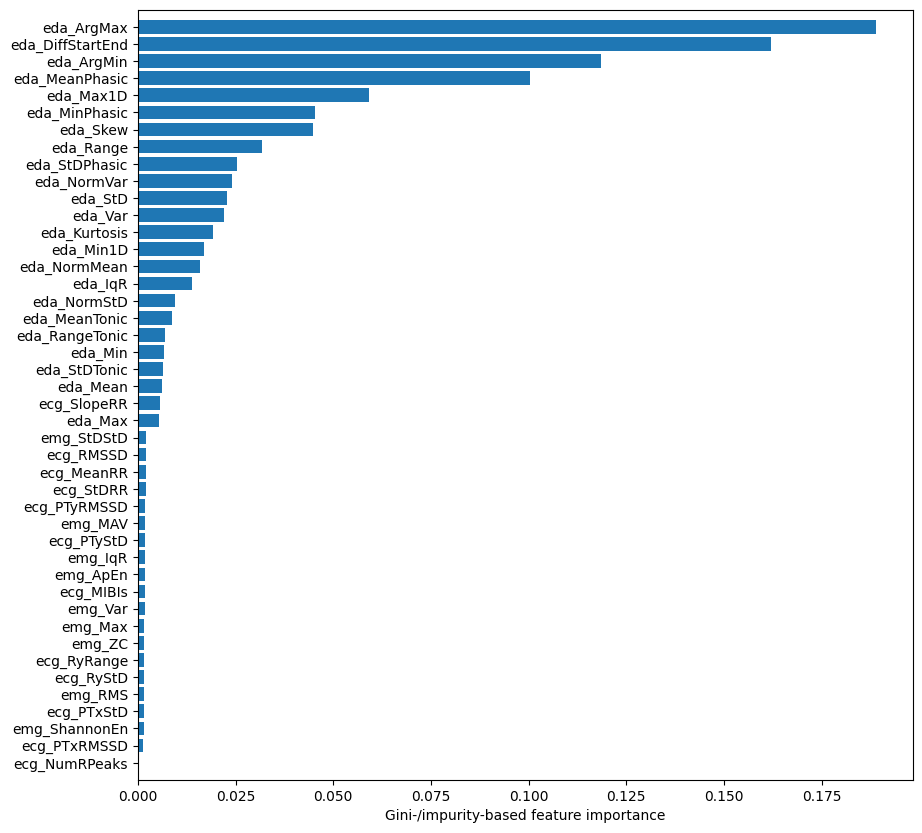

['eda_ArgMax' 'eda_DiffStartEnd' 'eda_ArgMin' 'eda_MeanPhasic' 'eda_Max1D'
 'eda_MinPhasic' 'eda_Skew' 'eda_Range' 'eda_StDPhasic' 'eda_NormVar'
 'eda_StD' 'eda_Var' 'eda_Kurtosis' 'eda_Min1D' 'eda_NormMean' 'eda_IqR'
 'eda_NormStD' 'eda_MeanTonic' 'eda_RangeTonic' 'eda_Min' 'eda_StDTonic'
 'eda_Mean' 'ecg_SlopeRR' 'eda_Max' 'emg_StDStD' 'ecg_RMSSD' 'ecg_MeanRR'
 'ecg_StDRR' 'ecg_PTyRMSSD' 'emg_MAV' 'ecg_PTyStD' 'emg_IqR' 'emg_ApEn'
 'ecg_MIBIs' 'emg_Var' 'emg_Max' 'emg_ZC' 'ecg_RyRange' 'ecg_RyStD'
 'emg_RMS' 'ecg_PTxStD' 'emg_ShannonEn' 'ecg_PTxRMSSD' 'ecg_NumRPeaks']


In [8]:
plot_feature_importance(evaluation)
print(np.array(evaluation['X_train'].columns)[np.argsort(evaluation['feature_importance'])[::-1]])

In [5]:
# recursive feature elimination
def rfe(features, stats=None):
    if stats is None:
        stats = {'used_features': [], 'evaluations': []}
        
    clf = RandomForestClassifier(random_state=42, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=120)
    evaluation = leave_one_subject_out_CV(features, clf)
    stats['used_features'].append(list(features.columns[:-2]))
    stats['evaluations'].append(evaluation)
    if len(features.columns) == 3:
        return stats
    least_important = np.argmin(evaluation['feature_importance'])
    features = features.drop(features.columns[least_important], axis=1)
    return rfe(features, stats)

In [ ]:
def plot_rfe(stats, y_lim_bottom=0.72):
    fig, ax = plt.subplots(figsize=(10, 6))

    auc_list = [evaluation['avg_auc'] for evaluation in stats['evaluations']]
    acc_list = [evaluation['avg_acc'] for evaluation in stats['evaluations']]
    prec_list = [evaluation['avg_prec'] for evaluation in stats['evaluations']]
    rec_list = [evaluation['avg_rec'] for evaluation in stats['evaluations']]

    ax.plot(range(0, len(stats['used_features'])), auc_list, label='AUC', color='tab:red', marker='o')
    ax.plot(range(0, len(stats['used_features'])), acc_list, label='Accuracy', color='tab:blue', marker='s')
    ax.plot(range(0, len(stats['used_features'])), rec_list, label='Recall', color='tab:orange', marker='x')
    ax.plot(range(0, len(stats['used_features'])), prec_list, label='Precision', color='tab:green', marker='^')

    ax.set_ylabel('Score')
    ax.set_xlabel('Least Important Feature')
    ax.set_xticks(range(len(stats['used_features'])))
    ax.set_xticklabels([list(set(stats['used_features'][i]) - set(stats['used_features'][i + 1]))[0] if i < len(stats['used_features']) - 1 else stats['used_features'][i][0] for i in range(len(stats['used_features']))], rotation=90)

    # Vertical lines at max AUC and accuracy
    ax.axvline(x=np.argmax(auc_list), color='tab:red', linestyle='--', label='Number of Features for max AUC', alpha=0.9)
    ax.axvline(x=np.argmax(acc_list), color='tab:blue', linestyle='--', label='Number of Features for max Accuracy', alpha=0.9)

    # Second x-axis for number of used features
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(range(len(stats['used_features'])))
    xtick_labels = [len(f) for f in stats['used_features']]
    ax2.set_xticklabels([label if i % 2 != 0 else '' for i, label in enumerate(xtick_labels)])
    ax2.set_xlabel('Number of Features')

    ax.legend(loc='lower left')
    plt.ylim(bottom=y_lim_bottom)
    plt.show()

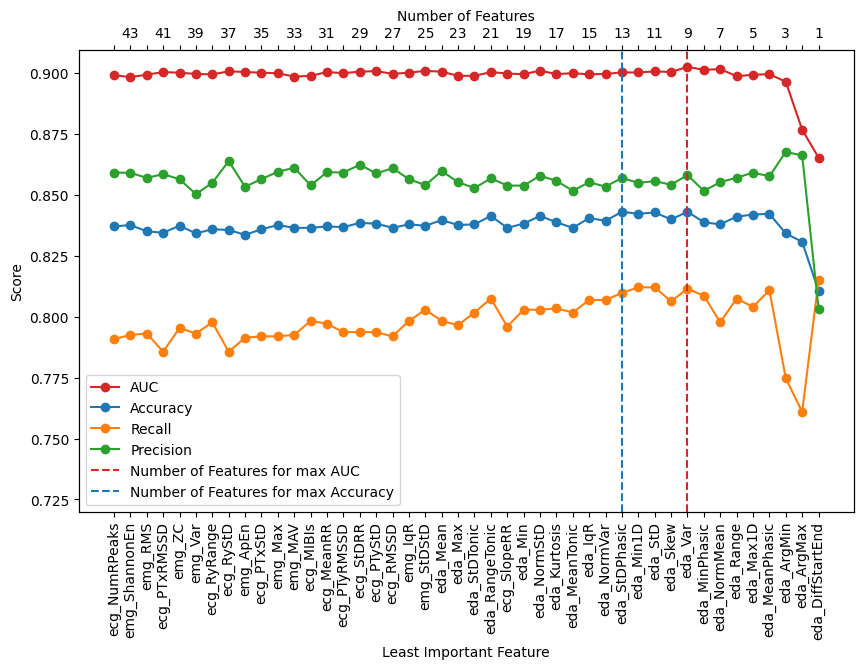

In [78]:
stats = rfe(df)
plot_rfe(rfe(df))

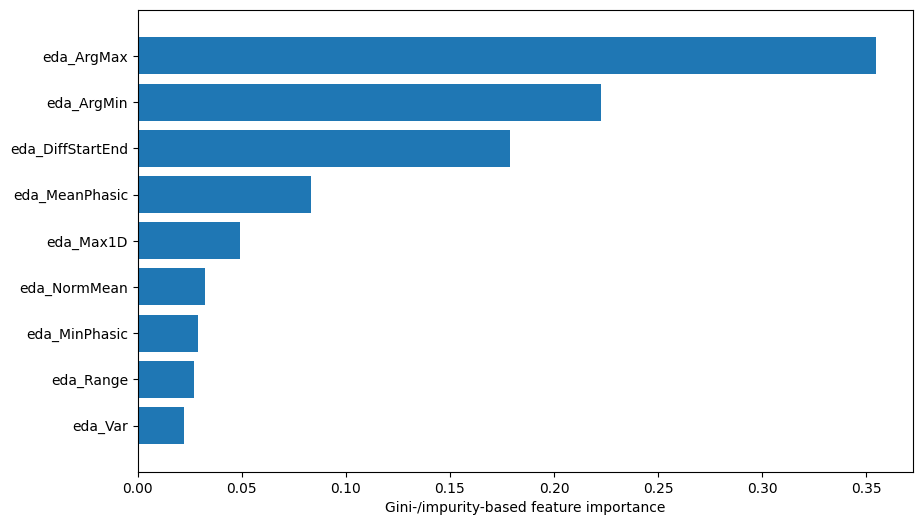

In [94]:
# plot feature importance of top 9 features
plot_feature_importance(stats['evaluations'][-9], figsize=(10, 6))

In [7]:
def print_evaluation(evaluation):
    print(f"Avg accuracy: {evaluation['avg_acc']:.4f} ± {evaluation['std_acc']:.4f}")
    print(f"Avg precision: {evaluation['avg_prec']:.4f} ± {evaluation['std_prec']:.4f}")
    print(f"Avg recall: {evaluation['avg_rec']:.4f} ± {evaluation['std_rec']:.4f}")
    print(f"Avg AUC: {evaluation['avg_auc']:.4f} ± {evaluation['std_auc']:.4f}")

## Final Results
(All features considered, only EDA features selected)

In [ ]:
top_features = ['eda_ArgMax', 'eda_ArgMin', 'eda_DiffStartEnd', 'eda_MeanPhasic', 'eda_Max1D','eda_NormMean', 'eda_MinPhasic','eda_Range', 'eda_Var']
clf = RandomForestClassifier(random_state=42, **params)
evaluation = leave_one_subject_out_CV(df[top_features + ['subject_id', 'class']], clf)
print_evaluation(evaluation)

Avg accuracy: 0.8417 ± 0.1338
Avg precision: 0.8563 ± 0.1173
Avg recall: 0.8080 ± 0.2197
Avg AUC: 0.9008 ± 0.1233


## ECG

In [ ]:
stats_ecg = rfe(df[df.columns[df.columns.str.startswith('ecg')].tolist() + ['subject_id', 'class']])

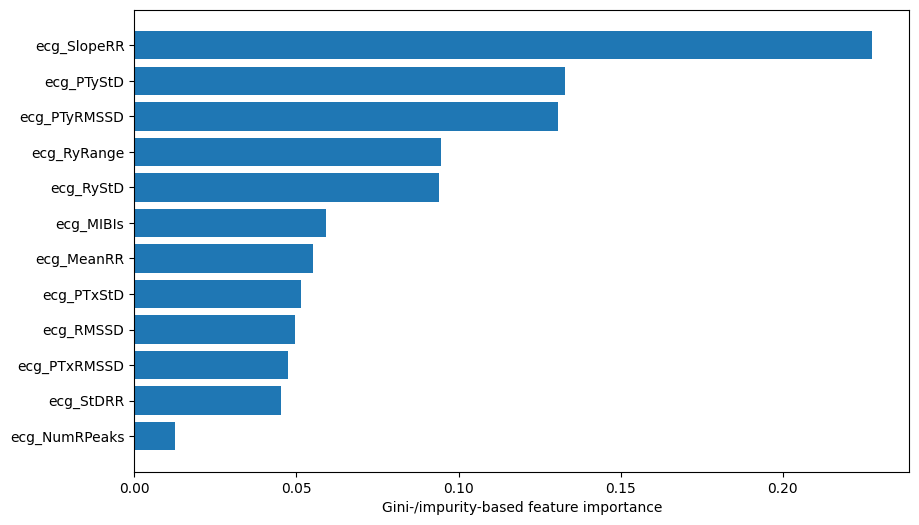

In [9]:
plot_feature_importance(stats_ecg['evaluations'][0], figsize=(10, 6))

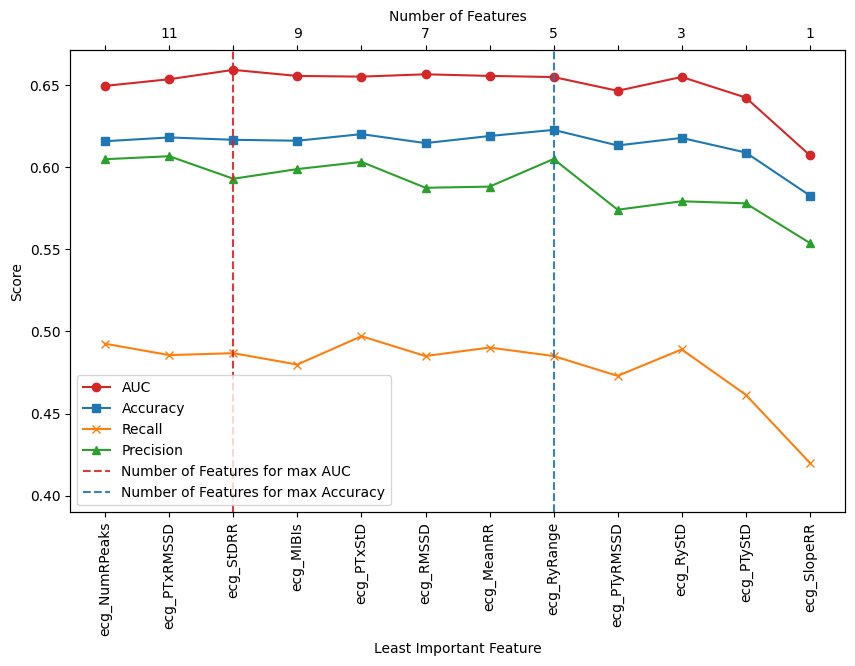

In [11]:
plot_rfe(stats_ecg, y_lim_bottom=0.39)

In [ ]:
top_ecg_features = ['ecg_SlopeRR', 'ecg_PTyStD', 'ecg_RyStD', 'ecg_PTyRMSSD', 'ecg_RyRange', 'ecg_MeanRR', 'ecg_RMSSD', 'ecg_PTxStD', 'ecg_MIBIs', 'ecg_StDRR']
clf = RandomForestClassifier(random_state=42, **params)
evaluation = leave_one_subject_out_CV(df[top_ecg_features + ['subject_id', 'class']], clf)
print_evaluation(evaluation)

Avg accuracy: 0.6129 ± 0.1463
Avg precision: 0.5919 ± 0.2674
Avg recall: 0.4833 ± 0.3339
Avg AUC: 0.6520 ± 0.2058


## EMG

In [ ]:
stats_emg = rfe(df[df.columns[df.columns.str.startswith('emg')].tolist() + ['subject_id', 'class']])

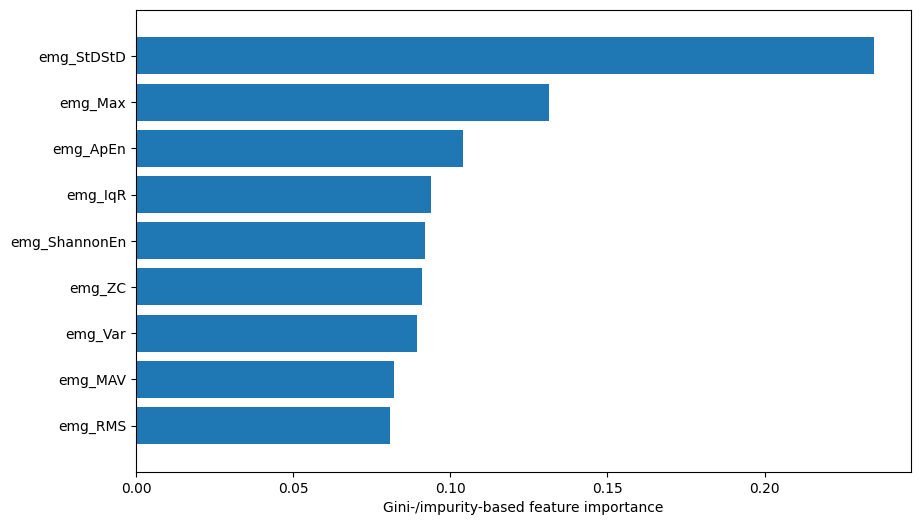

In [14]:
plot_feature_importance(stats_emg['evaluations'][0], figsize=(10, 6))

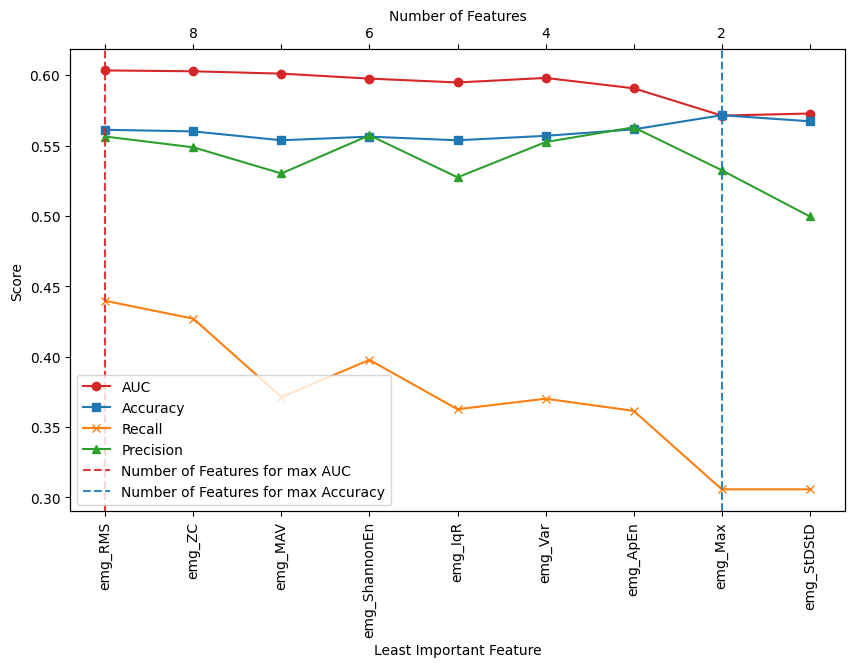

In [ ]:
plot_rfe(stats_emg, y_lim_bottom=0.29)

In [ ]:
top_emg_features = ['emg_StDStD', 'emg_Max', 'emg_ApEn', 'emg_Var', 'emg_IqR', 'emg_ShannonEn','emg_MAV','emg_ZC', 'emg_RMS']
clf = RandomForestClassifier(random_state=42, **params)
evaluation = leave_one_subject_out_CV(df[top_emg_features + ['subject_id', 'class']], clf)
print_evaluation(evaluation)

Avg accuracy: 0.5670 ± 0.1291
Avg precision: 0.5798 ± 0.2286
Avg recall: 0.4506 ± 0.3067
Avg AUC: 0.6043 ± 0.1846
